# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any electorates over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [3]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

C:\Users\Rudol\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [4]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [5]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


# DEFINITION OF INDEX

from here https://www.abs.gov.au/ausstats/abs@.nsf/Lookup/by%20Subject/2033.0.55.001~2016~Main%20Features~IRSAD~20

4 major indexes for every LGA. 

**IRSAD: index of relative socio economic advantage and disadvantage.**
- summarises information about the economic and social conditions of people and households within an area. Includes both relative advantage and disadvantage. 
- low score = greater disadvatange, lack of advantage in general. 
- low scores = many households with low incomes, many people in unskilled occupations. OR few households with high incomes. Few people in skilled occupations. 

**IEO: Index of education and occupation.**
- reflects the educational and occupational level of communities. 
- Education variables in this index show either the level of qualification achieved or wheteher further education is being undertaken. 
- Low score = relatively lower education and occupation status. 
- low score = many people without qualifications or many people in low skilled occuaptions or unemployed. AND few people with high level of qualification or highly skilled occupation. 

**IER: Index of economic resources.**
- focus' on the financial aspects of relative socio-economic advantage and disadvantage. Summarises variables related to income and wealth. 
- low score = relative lack to economic resources in general. 
- low score = many households with low income, or many paying low rent. AND few households with high income, or few owned homes. 

**IRSD: The index of relative socio economic disadvantage.**
- range of information about the economic and social conditions of people and households. 
- low score = relatively greater disadvantage in general. 
- low sore= many households with low income, people with no qualification OR many people in low skill occupations. 

### Voucher dataset
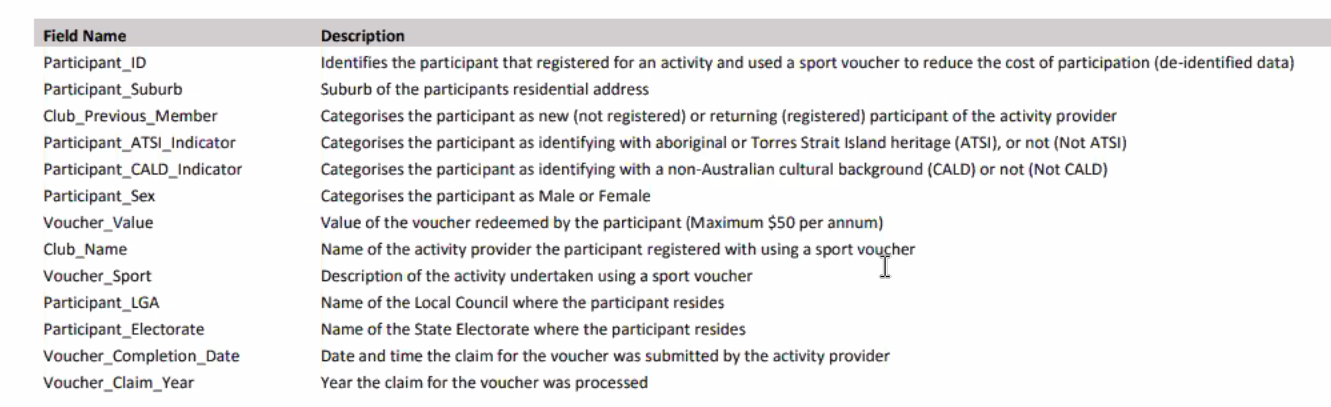

# Q1 Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?

We can assume each row means a voucher has been claimed. 

Start off by checking how many unique LGAs there are. Then we can count how many times the LGA occurs. 

In [6]:
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [7]:
len(set(sa_vouchers_scores['Participant_LGA']))

69

In [8]:
lgaSportGrouped = (sa_vouchers_scores.groupby(['Participant_LGA','Voucher_Sport']).count()).copy(deep=True)

In [9]:
lgaSportGrouped

Participant_ID  Participant_Suburb  \
Participant_LGA Voucher_Sport                                          
ADELAIDE        Athletics                     16                  16   
                Australian Rules             130                 130   
                Baseball                       1                   1   
                Basketball                     4                   4   
                Calisthenics                   1                   1   
...                                          ...                 ...   
YORKE PENINSULA Motorcycling                   2                   2   
                Netball                      313                 313   
                Surf Lifesaving                4                   4   
                Taekwondo                     87                  87   
                Tennis                         9                   9   

                                  Club_Previous_Member  \
Participant_LGA Voucher_Sport                            
ADELAIDE        Athletics                           16   
                Australian Rules                   130   
                Baseball                             1   
                Basketball                           4   
                Calisthenics                         1   
...                                                ...   
YORKE PENINSULA Motorcycling                         2   
                Netball                            313   
                Surf Lifesaving                      4   
                Taekwondo                           87   
                Tennis                               9   

                                  Participant_ATSI_Indicator  \
Participant_LGA Voucher_Sport                                  
ADELAIDE        Athletics                                 16   
                Australian Rules                         130   
                Baseball                                   1   
                Basketball                                 4   
                Calisthenics                               1   
...                                                      ...   
YORKE PENINSULA Motorcycling                               2   
                Netball                                  313   
                Surf Lifesaving                            4   
                Taekwondo                                 87   
                Tennis                                     9   

                                  Participant_CALD_Indicator  Participant_Sex  \
Participant_LGA Voucher_Sport                                                   
ADELAIDE        Athletics                                 16               16   
                Australian Rules                         130              130   
                Baseball                                   1                1   
                Basketball                                 4                4   
                Calisthenics                               1                1   
...                                                      ...              ...   
YORKE PENINSULA Motorcycling                               2                2   
                Netball                                  313              313   
                Surf Lifesaving                            4                4   
                Taekwondo                                 87               87   
                Tennis                                     9                9   

                                  Voucher_Value  Club_Name  \
Participant_LGA Voucher_Sport                                
ADELAIDE        Athletics                    16         16   
                Australian Rules            130        130   
                Baseball                      1          1   
                Basketball                    4          4   
                Calisthenics                  1          1   
...                  

In [10]:
adelaide = lgaSportGrouped[lgaSportGrouped.index.get_level_values('Participant_LGA') == 'ADELAIDE']

C:\Users\Rudol\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

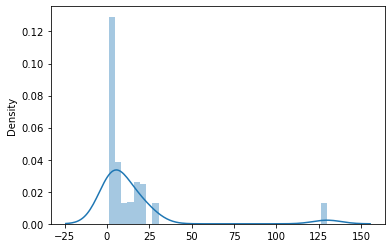

In [11]:
sns.distplot(lgaSportGrouped[lgaSportGrouped.index.get_level_values('Participant_LGA') == 'ADELAIDE'])

In [12]:
adelaide['Participant_ID']

Participant_LGA  Voucher_Sport    
ADELAIDE         Athletics             16
                 Australian Rules     130
                 Baseball               1
                 Basketball             4
                 Calisthenics           1
                 Cricket                2
                 Diving                 5
                 Fencing                3
                 Football (Soccer)     27
                 Golf                   1
                 Gymnastics            20
                 Hockey                17
                 Judo                   4
                 Lacrosse               8
                 Netball               23
                 Orienteering           6
                 Rugby Union            3
                 Softball               2
                 Surf Lifesaving       14
                 Taekwondo             11
                 Tennis                 4
Name: Participant_ID, dtype: int64

# check groupby and pivot table to do this better. 

In [13]:
sportNames = adelaide.index.get_level_values('Voucher_Sport').values

In [14]:
test = pd.DataFrame({'sport':sportNames, 'count': adelaide['Participant_ID'].values})

In [15]:
test['sport'].iloc[0]

'Athletics'

<AxesSubplot:>

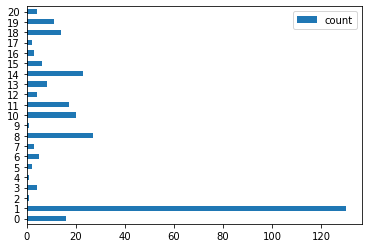

In [16]:
test.plot.barh()

Checking the top ten sports

https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.nlargest.html

### let's try the above but with a pivot table instead 

used help from the textbook for this part. Page 24, section 2.6.8



In [17]:
group = (sa_vouchers_scores.groupby(['Participant_LGA','Voucher_Sport']).count()).copy(deep=True)

In [18]:
group.columns

Index(['Participant_ID', 'Participant_Suburb', 'Club_Previous_Member',
       'Participant_ATSI_Indicator', 'Participant_CALD_Indicator',
       'Participant_Sex', 'Voucher_Value', 'Club_Name',
       'Participant_Electorate', 'Voucher_Completion_Date',
       'Voucher_Claim_Year', 'IEO', 'IER', 'IRSAD', 'IRSD', 'Population'],
      dtype='object')

keeping all rows and only keeping one column. All the columns represent the same number of counts, so we only need to keep one. 

In [19]:
group

Participant_ID  Participant_Suburb  \
Participant_LGA Voucher_Sport                                          
ADELAIDE        Athletics                     16                  16   
                Australian Rules             130                 130   
                Baseball                       1                   1   
                Basketball                     4                   4   
                Calisthenics                   1                   1   
...                                          ...                 ...   
YORKE PENINSULA Motorcycling                   2                   2   
                Netball                      313                 313   
                Surf Lifesaving                4                   4   
                Taekwondo                     87                  87   
                Tennis                         9                   9   

                                  Club_Previous_Member  \
Participant_LGA Voucher_Sport                            
ADELAIDE        Athletics                           16   
                Australian Rules                   130   
                Baseball                             1   
                Basketball                           4   
                Calisthenics                         1   
...                                                ...   
YORKE PENINSULA Motorcycling                         2   
                Netball                            313   
                Surf Lifesaving                      4   
                Taekwondo                           87   
                Tennis                               9   

                                  Participant_ATSI_Indicator  \
Participant_LGA Voucher_Sport                                  
ADELAIDE        Athletics                                 16   
                Australian Rules                         130   
                Baseball                                   1   
                Basketball                                 4   
                Calisthenics                               1   
...                                                      ...   
YORKE PENINSULA Motorcycling                               2   
                Netball                                  313   
                Surf Lifesaving                            4   
                Taekwondo                                 87   
                Tennis                                     9   

                                  Participant_CALD_Indicator  Participant_Sex  \
Participant_LGA Voucher_Sport                                                   
ADELAIDE        Athletics                                 16               16   
                Australian Rules                         130              130   
                Baseball                                   1                1   
                Basketball                                 4                4   
                Calisthenics                               1                1   
...                                                      ...              ...   
YORKE PENINSULA Motorcycling                               2                2   
                Netball                                  313              313   
                Surf Lifesaving                            4                4   
                Taekwondo                                 87               87   
                Tennis                                     9                9   

                                  Voucher_Value  Club_Name  \
Participant_LGA Voucher_Sport                                
ADELAIDE        Athletics                    16         16   
                Australian Rules            130        130   
                Baseball                      1          1   
                Basketball                    4          4   
                Calisthenics                  1          1   
...                  

In [20]:
group.loc[:, 'Participant_ID' ]

Participant_LGA  Voucher_Sport   
ADELAIDE         Athletics            16
                 Australian Rules    130
                 Baseball              1
                 Basketball            4
                 Calisthenics          1
                                    ... 
YORKE PENINSULA  Motorcycling          2
                 Netball             313
                 Surf Lifesaving       4
                 Taekwondo            87
                 Tennis                9
Name: Participant_ID, Length: 1157, dtype: int64

In [21]:
groupTest = group.loc[:, 'Participant_ID' ]

In [22]:
type(groupTest)

pandas.core.series.Series

we would use the below format to index into the series. Useful for filtering out the top ten sports, for example. We just specify which LGA we're interested in we will have the cocunts for eacch sport. 

perhaps this can be changed to have each column as a sport, each row as an LGA. I think this is where pivot table comes in handy. 

In [55]:
pivot = pd.pivot_table(group, values = 'Participant_ID', index = 'Participant_LGA', columns = 'Voucher_Sport')

In [56]:
pivot

Voucher_Sport,Archery,Athletics,Australian Rules,BMX,Badminton,Baseball,Basketball,Bowls,Calisthenics,Cricket,...,Surf Riding,Swimming,Table Tennis,Taekwondo,Tennis,Touch,Volleyball,Water Polo,Weightlifting,Wrestling
Participant_LGA,,,,,,,,,,,,,,,,,,,,,
ADELAIDE,NaN,16.0,130.0,NaN,NaN,1.0,4.0,NaN,1.0,2.0,...,NaN,NaN,NaN,11.0,4.0,NaN,NaN,NaN,NaN,NaN
ADELAIDE HILLS,3.0,204.0,1412.0,2.0,NaN,11.0,48.0,NaN,62.0,128.0,...,NaN,18.0,3.0,44.0,257.0,2.0,1.0,1.0,NaN,NaN
ADELAIDE PLAINS,NaN,3.0,485.0,NaN,NaN,3.0,15.0,NaN,23.0,3.0,...,NaN,3.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN
ALEXANDRINA,9.0,62.0,980.0,4.0,3.0,NaN,204.0,NaN,5.0,8.0,...,2.0,11.0,NaN,NaN,109.0,NaN,NaN,NaN,NaN,NaN
BAROSSA,NaN,158.0,1196.0,3.0,NaN,6.0,341.0,NaN,9.0,56.0,...,NaN,12.0,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEST TORRENS,1.0,114.0,907.0,2.0,NaN,12.0,70.0,NaN,45.0,85.0,...,NaN,80.0,4.0,27.0,158.0,1.0,4.0,2.0,NaN,NaN
WHYALLA,NaN,15.0,569.0,NaN,NaN,NaN,605.0,NaN,15.0,12.0,...,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WUDINNA,NaN,29.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
pivot = pivot.fillna(0)

before this step we had a series of 1100 odd rows. That in itself isn't too bad, but applying the pivot table has drastically aided in the dimensioniality of the DF,m making it easier to explore the D. I have also changed the NAN values to zero, making the assumption that the nan values represent no voucher redeemed. 

Let's try some plots with this new df now. 

from https://seaborn.pydata.org/examples/part_whole_bars.html

**Removing any uppercase words for ease of referencing the DF.**

help from https://www.codegrepper.com/code-examples/python/convert+columns+to+lowercase+pandas

In [60]:
pivot.index = pivot.index.str.lower()

In [62]:
pivot.columns = pivot.columns.str.lower()

In [72]:
pivot.index['adelaide':'adelaide hills']

TypeError: slice indices must be integers or None or have an __index__ method

TypeError: Horizontal orientation requires numeric `x` variable.

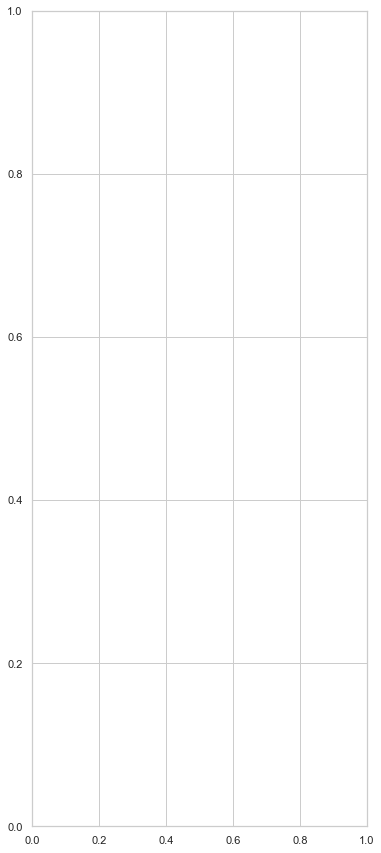

In [37]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))


# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x= pivot.index,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
# sns.barplot(x="alcohol", y="abbrev", data=crashes,
#             label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="test label")
sns.despine(left=True, bottom=True)

In [ ]:
pivot = pd.pivot_table(sa_vouchers_scores, 

# Q2 Are some sports more popular in different parts of the state?

# Q3 Are any LGAs over/under represented in their use of vouchers?

# Q4 Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [ ]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

In [ ]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()